In [31]:
from collections import defaultdict
import os
from datetime import datetime
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def get_video_duration(file_path):
    """
    Calculate the duration of a video file in seconds.
    Args:
        file_path (str): The path to the video file.
    Returns:
        float: The duration of the video in seconds, rounded to 2 decimal places.
               Returns 0 if there is an error or if the frames per second (fps) is 0.
    Raises:
        Exception: If there is an error in reading the video file, it will print an error message
                   and return 0.
    """
    
    try:
        video = cv2.VideoCapture(file_path)
        fps = video.get(cv2.CAP_PROP_FPS) #get the frames per second of the video file
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT) #get the total number of frames in the
        duration = frame_count / fps if fps > 0 else 0 #calculate the duration of the video in seconds
        video.release() #release the video object
        return round(duration, 2) #return the duration rounded to 2 decimal places
    except Exception as e:
        print(f"Error getting duration for {file_path}: {e}")
        return 0

In [33]:
def get_file_info(base_folder):
    """
    Collects information about video files in a given base folder.
    This function traverses the directory tree rooted at `base_folder`, and for each video file found,
    it gathers the following information:
    - File name
    - File size in megabytes (MB)
    - File format (extension)
    - Last modified time (formatted as 'YYYY-MM-DD HH:MM')
    - Duration of the video
    The collected information is organized by the name of the exercise (assumed to be the name of the folder
    containing the video files) and returned as a dictionary.
    Args:
        base_folder (str): The path to the base folder to start the directory traversal.
    Returns:
        dict: A dictionary where keys are exercise names (folder names) and values are lists of dictionaries,
              each containing information about a video file.
    """
    folder_stats = defaultdict(list) #create a defaultdict to store the information
    
    for root, _, files in os.walk(base_folder): #walk through the directory tree
        exercise_name = os.path.basename(root) #get the name of the exercise (folder name)
        
        for file in files:
            if file.lower().endswith(('.mp4', '.mov', '.avi', '.mkv', '.wmv')):
                file_path = os.path.join(root, file) #get the full path of the file
                try:
                    size_mb = round(os.path.getsize(file_path) / (1024 * 1024), 2) #get the file size in MB
                    mod_time = datetime.fromtimestamp(os.path.getmtime(file_path)) #get the last modified time
                    duration = get_video_duration(file_path) #get the duration of the video
                    
                    folder_stats[exercise_name].append({ #add the information to the defaultdict
                        'name': file,
                        'size_mb': size_mb,
                        'format': file.split('.')[-1],
                        'modified': mod_time.strftime('%Y-%m-%d %H:%M'),
                        'duration': duration
                    })
                except Exception as e:
                    print(f"Error processing {file}: {e}")
    
    return folder_stats

In [34]:
def format_duration(seconds):
    """
    Convert a duration from seconds to a formatted string in the format "MM:SS".

    Args:
        seconds (int): The duration in seconds.

    Returns:
        str: The formatted duration as a string in the format "MM:SS".
    """
    minutes = int(seconds // 60)
    remaining_seconds = int(seconds % 60)
    return f"{minutes}:{remaining_seconds:02d}"

In [35]:
def create_summary_dataframes(folder_stats):
    """
    Create summary and detailed dataframes from folder statistics.
    Parameters:
    folder_stats (dict): A dictionary where keys are exercise names and values are lists of video metadata dictionaries.
                         Each video metadata dictionary should contain:
                         - 'name' (str): Name of the video.
                         - 'format' (str): Format of the video.
                         - 'size_mb' (float): Size of the video in megabytes.
                         - 'duration' (int): Duration of the video in seconds.
                         - 'modified' (str): Last modified date of the video.
    Returns:
    tuple: A tuple containing:
           - summary_df (pd.DataFrame): A dataframe summarizing the statistics for each exercise.
           - detailed_df (pd.DataFrame): A dataframe containing detailed information for each video.
    """
    summary_data = []
    detailed_data = []
    
    for exercise, videos in folder_stats.items():
        if videos:
            formats = {}
            total_size = 0
            total_duration = 0
            sizes = []
            durations = []
            
            for video in videos:
                format_type = video['format']
                formats[format_type] = formats.get(format_type, 0) + 1
                total_size += video['size_mb']
                total_duration += video['duration']
                sizes.append(video['size_mb'])
                durations.append(video['duration'])
            
            summary_data.append({
                'Exercise': exercise,
                'Total Videos': len(videos),
                'Formats': ', '.join(f"{fmt}: {count}" for fmt, count in formats.items()),
                'Total Size (MB)': round(total_size, 2),
                'Size Std (MB)': round(pd.Series(sizes).std(), 2) if len(sizes) > 1 else 0,
                'Total Duration': format_duration(total_duration),
                'Duration Std': format_duration(pd.Series(durations).std()) if len(durations) > 1 else "0:00"
            })
            
            for video in videos:
                detailed_data.append({
                    'Exercise': exercise,
                    'Video Name': video['name'],
                    'Format': video['format'],
                    'Size (MB)': video['size_mb'],
                    'Duration': format_duration(video['duration']),
                    'Last Modified': video['modified']
                })
    
    summary_df = pd.DataFrame(summary_data)
    detailed_df = pd.DataFrame(detailed_data)
    
    # Add total row to summary DataFrame
    total_row = {
        'Exercise': 'Total',
        'Total Videos': summary_df['Total Videos'].sum(),
        'Formats': 'All',
        'Total Size (MB)': summary_df['Total Size (MB)'].sum(),
        'Size Std (MB)': summary_df['Size Std (MB)'].mean(),  # Average of standard deviations
        'Total Duration': format_duration(sum(pd.Series([int(x.split(':')[0])*60 + int(x.split(':')[1]) 
                                               for x in summary_df['Total Duration']]))),
        'Duration Std': format_duration(pd.Series([int(x.split(':')[0])*60 + int(x.split(':')[1]) 
                                                 for x in summary_df['Duration Std']]).mean())
    }
    summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)
    
    return summary_df, detailed_df

In [36]:
# Usage example:
base_folder = r"D:\minor\Upper_body dataset"
folder_stats = get_file_info(base_folder)
summary_df, detailed_df = create_summary_dataframes(folder_stats)


In [37]:
# Display the DataFrames (optional)
print("\nExercise Summary:")
print(summary_df.to_string())
print("\nDetailed Video List:")
print(detailed_df.to_string())


Exercise Summary:
              Exercise  Total Videos          Formats  Total Size (MB)  Size Std (MB) Total Duration Duration Std
0  barbell biceps curl            62          mp4: 62            82.84       1.670000           3:58         0:02
1          hammer curl            19  MOV: 7, mp4: 12           364.64      19.800000           3:05         0:05
2         lat pulldown            51          mp4: 51           107.20       2.220000           3:41         0:02
3        lateral raise            37  MOV: 6, mp4: 31           422.71      16.900000           5:07         0:04
4              pull Up            26          mp4: 26           140.04       6.400000           3:29         0:05
5              push-up            56          mp4: 56            68.65       2.160000           5:31         0:04
6       shoulder press            17  MOV: 4, mp4: 13           299.12      23.260000           2:59         0:04
7                Total           268              All          1485.2

In [38]:
def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

In [39]:
detailed_df['Duration_Seconds'] = detailed_df['Duration'].apply(time_to_seconds)


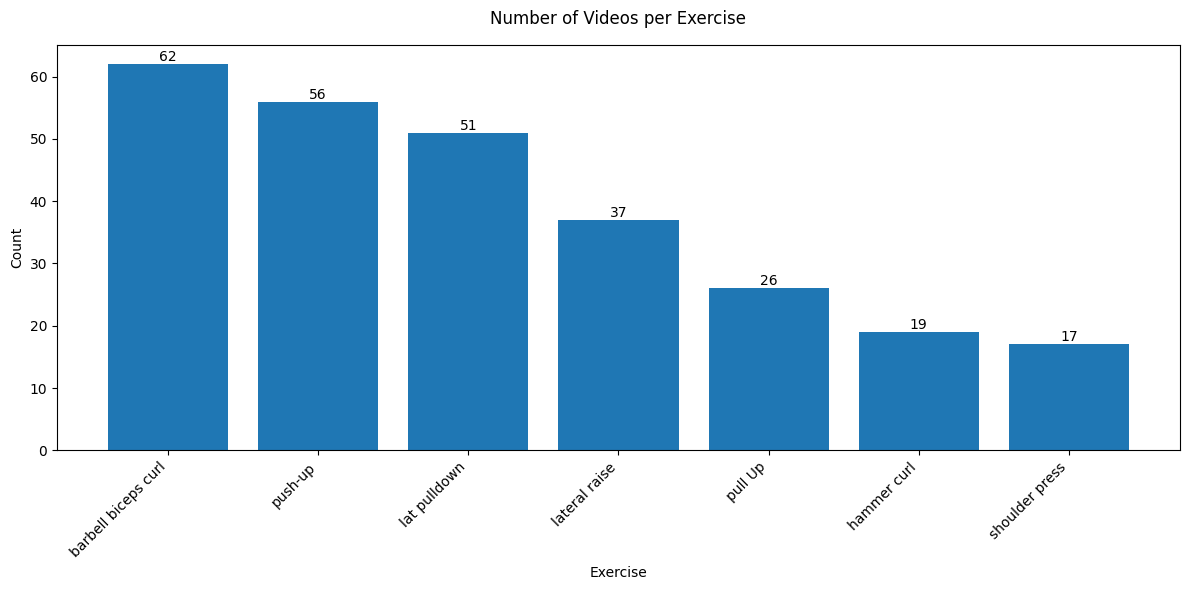

In [40]:

# Set figure size
fig_size = (12, 6)
# 1. Bar plot of video count by exercise
plt.figure(figsize=fig_size)
count_data = detailed_df['Exercise'].value_counts()
bars = plt.bar(count_data.index, count_data.values)
plt.title('Number of Videos per Exercise', pad=15, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Count')
# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
plt.tight_layout()
plt.savefig(r'D:\minor\k_fold_CNN_LSTM_landmark\figs\videos_per_exercise.png')
plt.show()


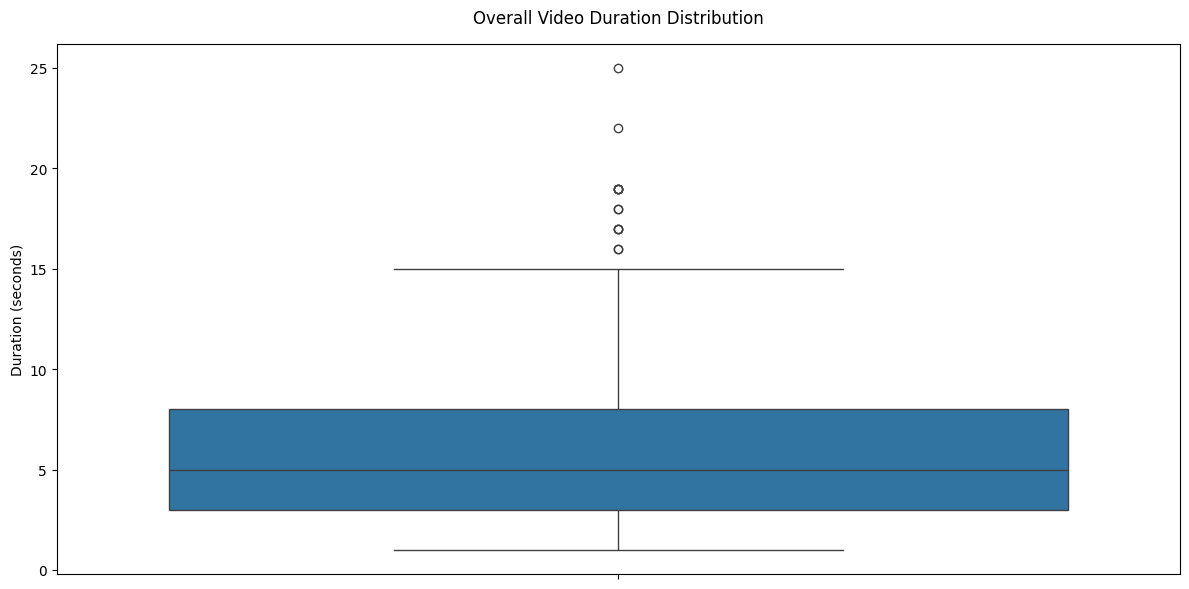

In [41]:
# New addition: Single boxplot for all video durations
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, y='Duration_Seconds')
plt.title('Overall Video Duration Distribution', pad=15, fontsize=12)
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.savefig(r'D:\minor\k_fold_CNN_LSTM_landmark\figs\overall_duration_distribution.png')
plt.show()

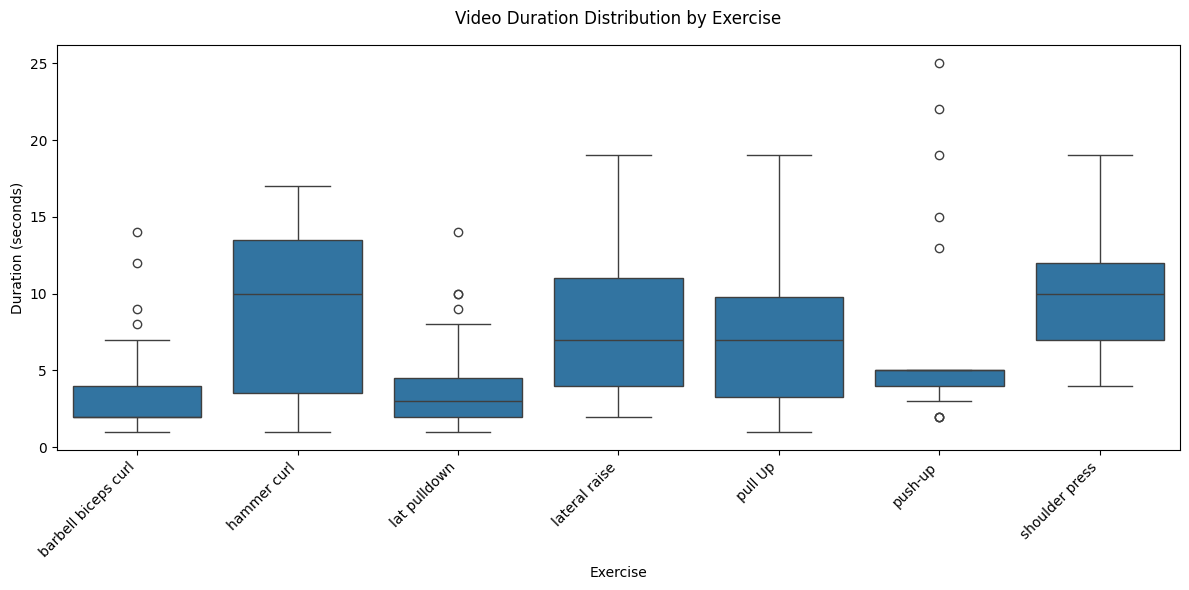

In [42]:
# 2. Box plot for Duration by Exercise
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, x='Exercise', y='Duration_Seconds')
plt.title('Video Duration Distribution by Exercise', pad=15, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.savefig(r'D:\minor\k_fold_CNN_LSTM_landmark\figs\duration_by_exercise.png')
plt.show()

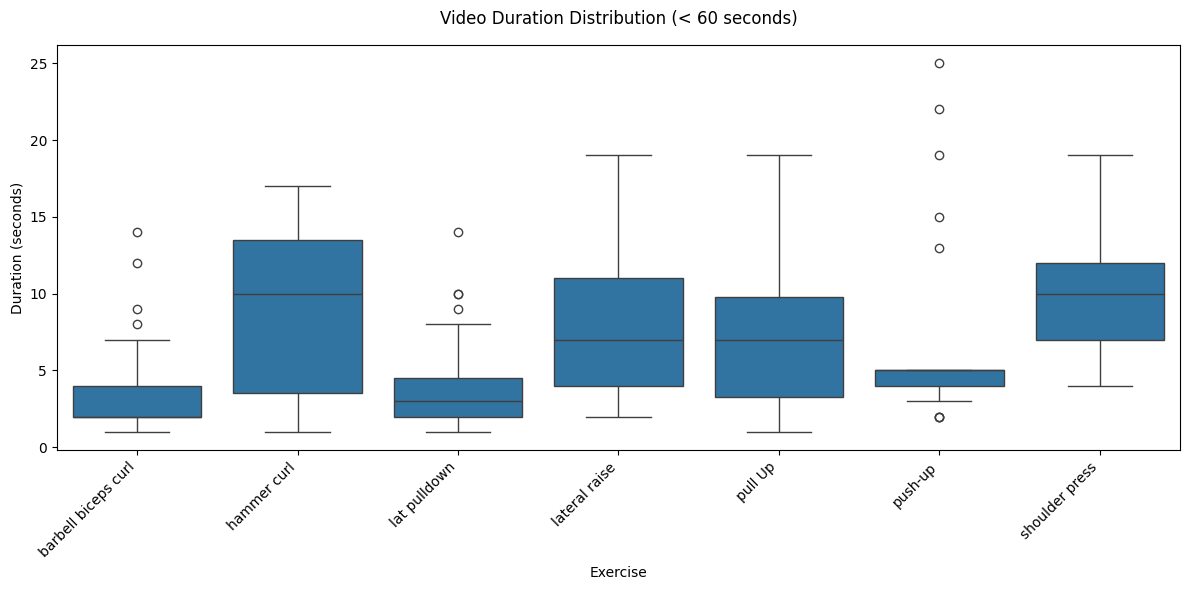

In [43]:
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df[detailed_df['Duration_Seconds']<60], y='Duration_Seconds', x='Exercise') 
plt.title('Video Duration Distribution (< 60 seconds)', pad=15, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.savefig(r'D:\minor\k_fold_CNN_LSTM_landmark\figs\duration_by_exercise_under_60s.png')
plt.show()


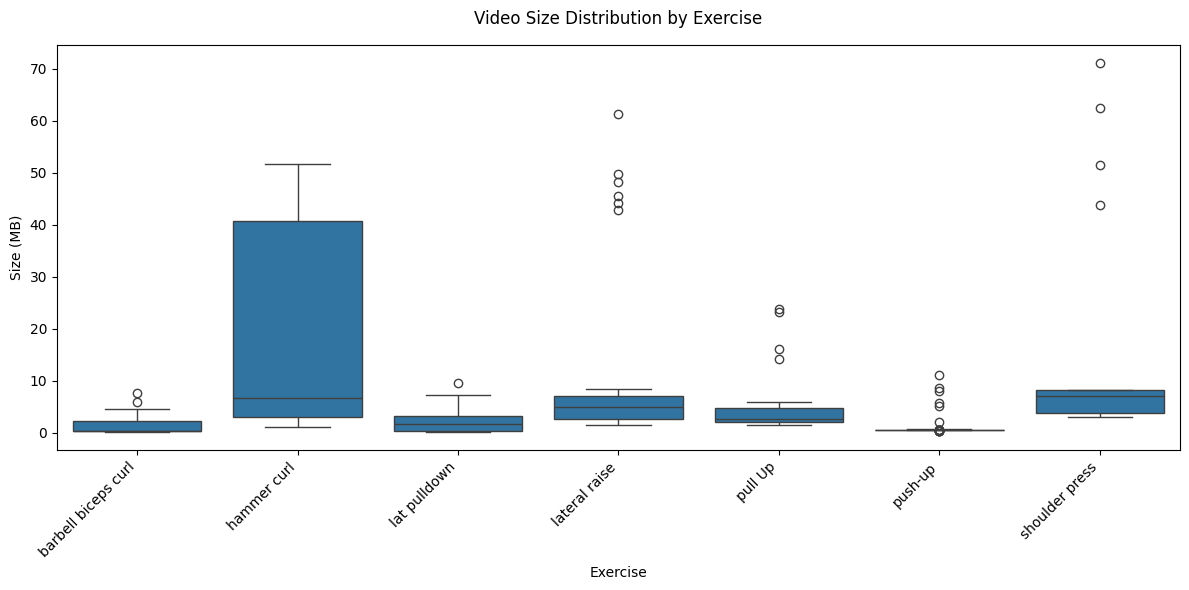

In [44]:
# 3. Box plot for Size by Exercise
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, x='Exercise', y='Size (MB)')
plt.title('Video Size Distribution by Exercise', pad=15, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Size (MB)')
plt.tight_layout()
plt.savefig(r'D:\minor\k_fold_CNN_LSTM_landmark\figs\size_by_exercise.png')
plt.show()
